<a href="https://colab.research.google.com/github/rodrigorissettoterra/Machine-Learning/blob/main/Boston_Housing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston Housing Dataset

## Setup + Carregamento do dataset

In [3]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# Para correlação (Pearson)
from scipy.stats import pearsonr

# Reprodutibilidade
RANDOM_STATE = 42

# Carregar Boston Housing via OpenML
boston = fetch_openml(name="boston", version=1, as_frame=True)

X = boston.data
y = boston.target.astype(float)  # garantir numérico

df = pd.concat([X, y.rename("medv")], axis=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Definição dos modelos (4 metodologias)

In [4]:
models = {
    "Regressão Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "Árvore de Regressão": DecisionTreeRegressor(
        random_state=RANDOM_STATE
    ),

    "Bagging (árvores)": BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    "Random Forest": RandomForestRegressor(
        n_estimators=500,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

## Função de avaliação LOOCV (MSE + Correlação)

In [5]:
def evaluate_loocv(model, X, y):
    loo = LeaveOneOut()

    # cross_val_predict gera y_pred para cada amostra usando LOOCV
    y_pred = cross_val_predict(model, X, y, cv=loo, n_jobs=-1)

    mse = mean_squared_error(y, y_pred)
    corr, p_value = pearsonr(y, y_pred)

    return {
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "Correlação (r)": corr,
        "p-valor (r)": p_value,
        "y_pred": y_pred
    }

## Rodar a comparação e montar a tabela de resultados

In [6]:
results = {}
preds = {}

for name, model in models.items():
    out = evaluate_loocv(model, X, y)
    preds[name] = out.pop("y_pred")
    results[name] = out

results_df = pd.DataFrame(results).T.sort_values("MSE")
results_df

,MSE,RMSE,Correlação (r),p-valor (r)
Bagging (árvores),10.081832,3.175190,0.938748,2.441369e-235
Random Forest,10.093241,3.176986,0.938623,4.017426e-235
Árvore de Regressão,16.394783,4.049047,0.904629,8.289767e-189
Regressão Linear,23.725746,4.870908,0.848027,4.336453e-141


## Gráficos: observado vs predito (para discussão)

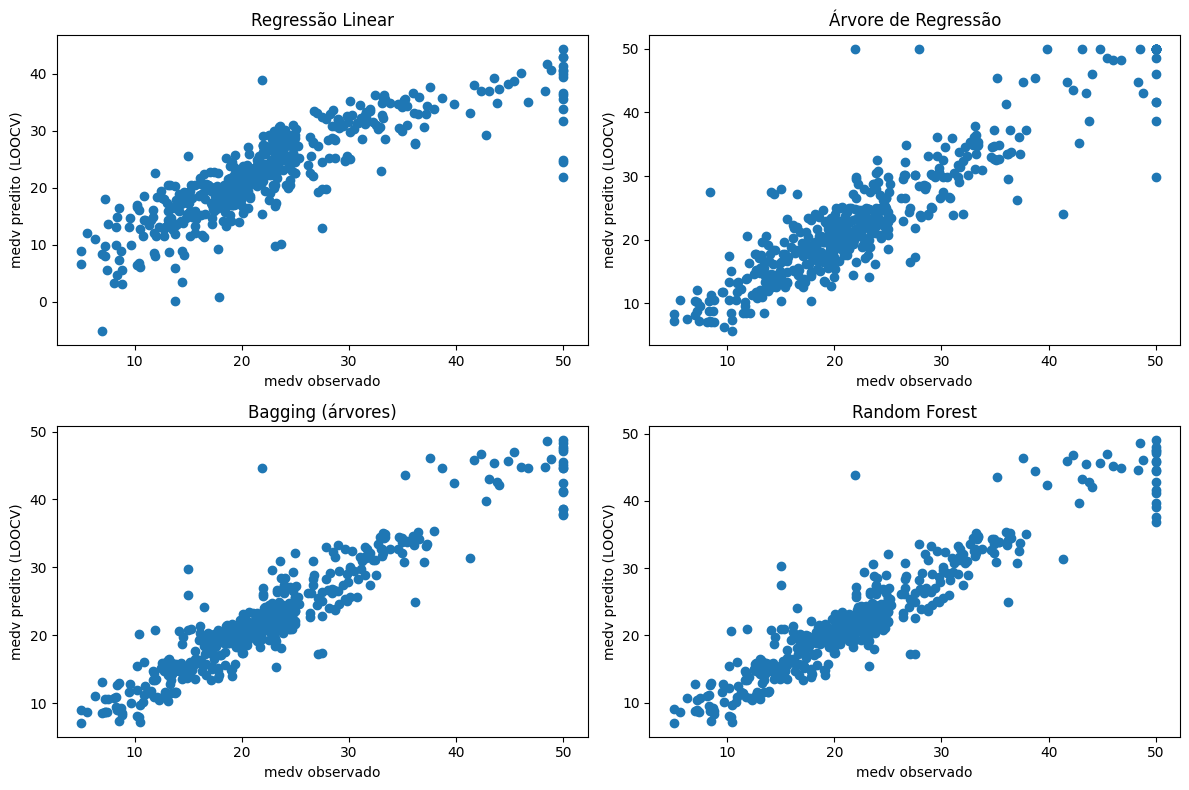

In [12]:
import matplotlib.pyplot as plt

y_true = y.values

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()  # transforma em vetor para iterar

for ax, name in zip(axes, models.keys()):
    y_pred = preds[name]

    ax.scatter(y_true, y_pred)
    ax.set_xlabel("medv observado")
    ax.set_ylabel("medv predito (LOOCV)")
    ax.set_title(f"{name}")

plt.tight_layout()
plt.show()

Gráfico de resíduos

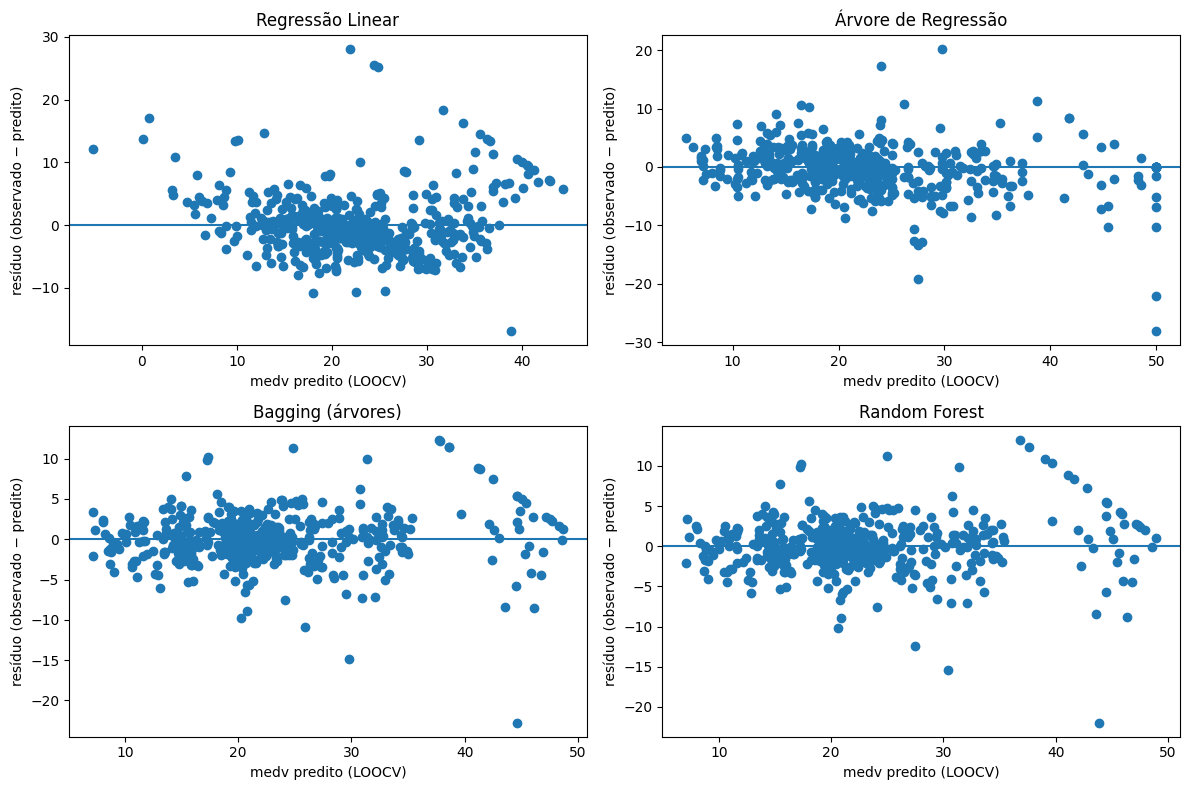

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, name in zip(axes, models.keys()):
    y_pred = preds[name]
    residuals = y_true - y_pred

    ax.scatter(y_pred, residuals)
    ax.axhline(0)
    ax.set_xlabel("medv predito (LOOCV)")
    ax.set_ylabel("resíduo (observado − predito)")
    ax.set_title(f"{name}")

plt.tight_layout()
plt.show()

## Relatório

In [15]:
best_model = results_df.index[0]
worst_model = results_df.index[-1]

print("RELATÓRIO — Predição de medv (Boston Housing) com LOOCV\n")

print("1. Objetivo")
print("Predizer o valor médio das casas ocupadas pelo proprietário (medv) a partir das variáveis explicativas,")
print("comparando quatro metodologias: Regressão Linear, Árvore de Regressão, Bagging e Random Forest.\n")

print("2. Metodologia")
print("- Dataset: Boston Housing (OpenML).")
print("- Validação: Leave-One-Out Cross-Validation (LOOCV).")
print("- Métricas: Erro Quadrático Médio (MSE) e correlação de Pearson (r) entre valores observados e preditos.")
print("- Implementação: scikit-learn; para cada modelo, foi obtida a predição LOOCV com cross_val_predict.\n")

print("3. Resultados (LOOCV)")
display(results_df)

print("\n4. Discussão")
print(f"- O melhor desempenho (menor MSE) foi do modelo: {best_model}.")
print(f"- O pior desempenho (maior MSE) foi do modelo: {worst_model}.")
print("- Em geral, modelos baseados em conjuntos (Bagging e Random Forest) tendem a reduzir variância e melhorar MSE")
print("  em comparação a uma única árvore, especialmente em dados com não-linearidades e interações.")
print("- A correlação (r) complementa o MSE: valores mais próximos de 1 indicam maior alinhamento entre tendência")
print("  predita e observada, mesmo quando há erros absolutos.\n")

print("5. Conclusão")
print("Com base nas métricas LOOCV, conclui-se que o modelo com melhor desempenho global é aquele com menor MSE")
print("e maior correlação. Recomenda-se reportar ambos e interpretar os gráficos (observado vs predito e resíduos)")
print("para identificar viés, heterocedasticidade e possíveis limitações.\n")

RELATÓRIO — Predição de medv (Boston Housing) com LOOCV

1. Objetivo
Predizer o valor médio das casas ocupadas pelo proprietário (medv) a partir das variáveis explicativas,
comparando quatro metodologias: Regressão Linear, Árvore de Regressão, Bagging e Random Forest.

2. Metodologia
- Dataset: Boston Housing (OpenML).
- Validação: Leave-One-Out Cross-Validation (LOOCV).
- Métricas: Erro Quadrático Médio (MSE) e correlação de Pearson (r) entre valores observados e preditos.
- Implementação: scikit-learn; para cada modelo, foi obtida a predição LOOCV com cross_val_predict.

3. Resultados (LOOCV)


,MSE,RMSE,Correlação (r),p-valor (r)
Bagging (árvores),10.081832,3.175190,0.938748,2.441369e-235
Random Forest,10.093241,3.176986,0.938623,4.017426e-235
Árvore de Regressão,16.394783,4.049047,0.904629,8.289767e-189
Regressão Linear,23.725746,4.870908,0.848027,4.336453e-141



4. Discussão
- O melhor desempenho (menor MSE) foi do modelo: Bagging (árvores).
- O pior desempenho (maior MSE) foi do modelo: Regressão Linear.
- Em geral, modelos baseados em conjuntos (Bagging e Random Forest) tendem a reduzir variância e melhorar MSE
  em comparação a uma única árvore, especialmente em dados com não-linearidades e interações.
- A correlação (r) complementa o MSE: valores mais próximos de 1 indicam maior alinhamento entre tendência
  predita e observada, mesmo quando há erros absolutos.

5. Conclusão
Com base nas métricas LOOCV, conclui-se que o modelo com melhor desempenho global é aquele com menor MSE
e maior correlação. Recomenda-se reportar ambos e interpretar os gráficos (observado vs predito e resíduos)
para identificar viés, heterocedasticidade e possíveis limitações.

